In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from results import *
from evaluate import *

sns.set_style("darkgrid")
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]
CMAP = sns.color_palette(flatui)
FIGSIZE = (13, 8)
POINT_SIZE = 60

Load the result json files into a custom class that gives easy access to evaluation metrics.

In [4]:
results = [Result.from_json(p) for p in Path("../analysis/").rglob("*.json")]

Turn results into a dataframe for plotting

In [8]:
results_dicts = [r.as_dict() for r in results]
results_df = pd.DataFrame(results_dicts)

# Metric definitions
The first thing we need to do is define some terminology that will be used for this analysis.

## True Positive (TP)
### Correct variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **correct** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Positive (FP)
### Incorrect variant allele or position call
This is defined as an entry in `pandora`'s VCF which, when taken with flanking sequence, maps over a variant position in the reference panel and has the **incorrect** base call at the expected position. *Note:* Mismatches are allowed in the flanks.

## False Negative (FN)
### Incorrect reference genotype or no call
This is defined as an entry in the reference panel which does not have any variants from `pandora`'s VCF that map across its variant position.  
*Note:* a `pandora` variant call can map to an entry in the reference panel but may not map across the middle position (which is the variant position).

## True Negative (TN)
### Correct reference genotype or no call
This is basically any position we have left the same as the reference correctly. True negatives would only really be relevant if we decided to apply the variant calls from `pandora` onto the consensus sequence from `pandora` and do a base-by-base comparison of that to the reference sequence.  
We will not consider TNs for the remainder of this analysis.

## Accuracy
### Ratio of correct calls to total calls and variants
**Calculation:** TP+~~TN~~/TP+FP+~~TN~~+FN  


## Specificity
### Non-variants not called as variants relative to the total non-variants
**Calculation:** TN/TN+FP

Not being used in this analysis due to the reliance on TNs.

## Sensitivity / Recall
### True variants called relative to all variants
**Calculation:** TP/TP+FN  


## Precision 
### True variants called relative to total calls 
**Calculation:** TP/TP+FP  


## False positive rate
### Non-variants called relative to the total non-variants
**Calculation:** FP/TN+FP  

Not being used in this analysis due to the reliance on TNs.

# Analysis
To begin with, let's plot the precision (y) and recall (x) but focusing purely on the candidate paths produced by *de novo* discovery. In this context, recall is defined as the percentage of simulated mutations where the mutant allele was included amongst the *de novo* slices. Precision is thus defined as the percentage of *de novo* slices that include a variant from the reference panel.  
For the plotting, we will colour (hue) the plot by the read quality. That is, were the simulated reads perfect (no errors) or imperfect (error profile from ONT R9 *E. coli* data).

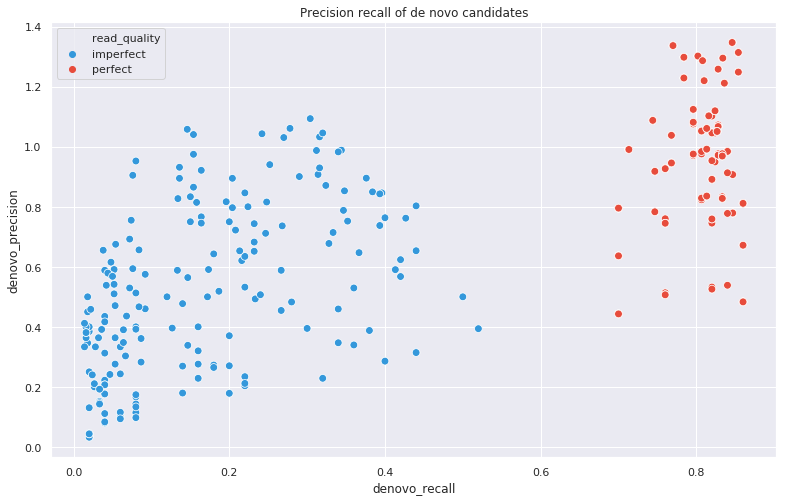

In [108]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=results_df, 
                       ax=ax,  
                       hue="read_quality", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates")

Next, lets look at a precision recall plot again, but this time using the entries in the VCF produced by `pandora`.

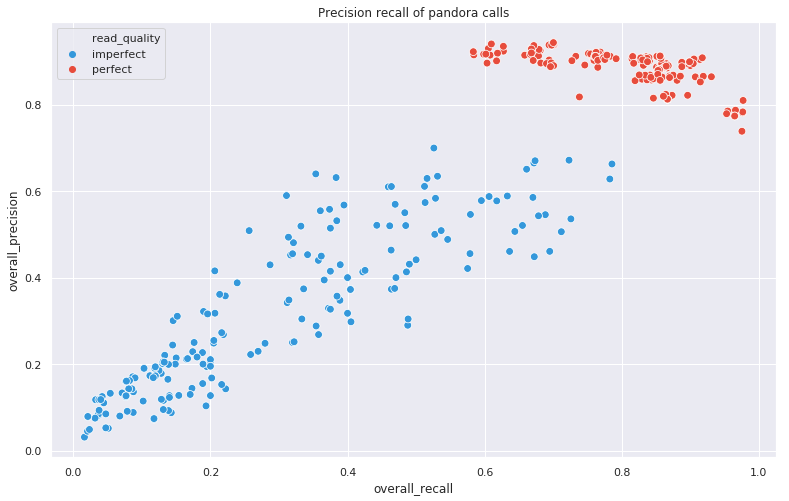

In [109]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=results_df, 
                       ax=ax,  
                       hue="read_quality", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls")

From both of these plots it is fairly clear that read quality makes a very big difference to the precision-recall relationship. As such, we can partition the data into perfect and imperfect sets to dig in to more detail about how the other parameters effect this relationship.

In [26]:
imperfect_df = results_df.drop(results_df[results_df.read_quality == "perfect"].index)
perfect_df = results_df.drop(results_df[results_df.read_quality == "imperfect"].index)

## Effect of coverage
Let's first take a look at how coverage effects the precision-recall relationship.

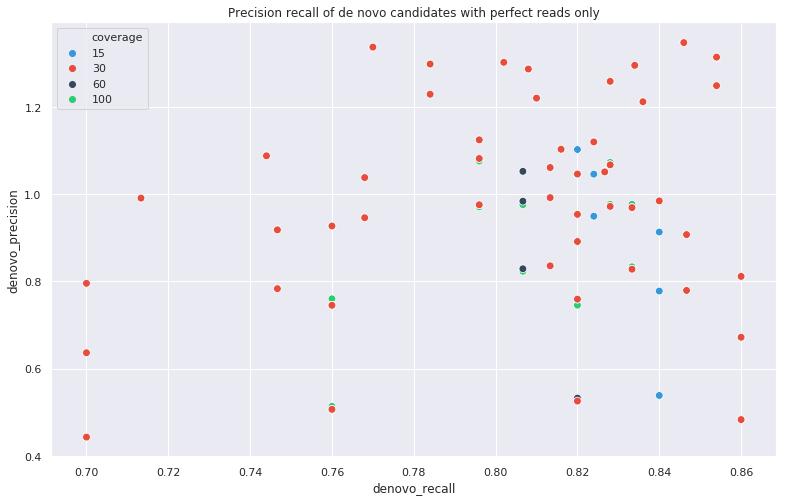

In [110]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")

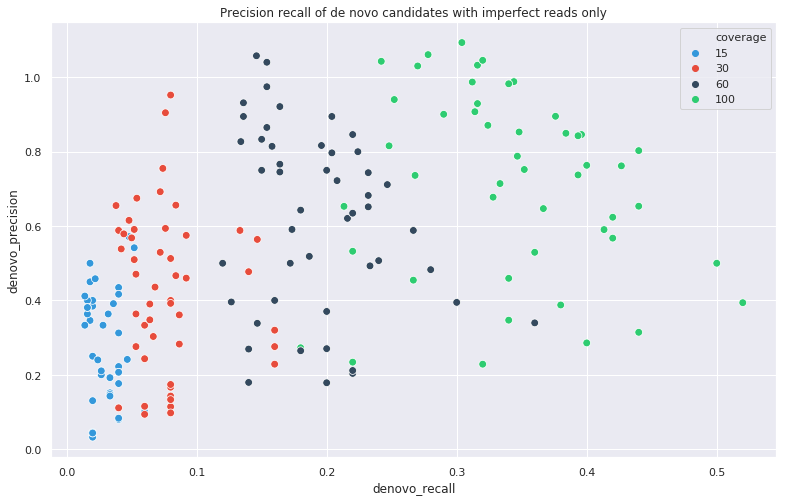

In [113]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")

These two plots show an interesting difference. For the perfect reads, there does not seem to be a requirement for any particular level of coverage, suggesting that for perfect reads, other parameters likely explain the variation. But for the imperfect reads it is very obvious that as you increase coverage, the number of variants you are able to discover increases also.  

From this we can also say that, in the best case, for imperfect reads with 100x coverage we are able to correctly discover about 45% of variants and that ~80% of the *de novo* slices contain a variant.  
For perfect reads, we can also say that, in the best case, we are able to correctly discover about 84% of variants and that ~98% of the *de novo* slices contain a variant. Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.  

*Note:* For the perfect reads plot, precision actually goes above 1.0. The reason for this is that in some cases we find multiple variants in the one *de novo* slice.

And now looking at the same thing from the VCF output of `pandora`

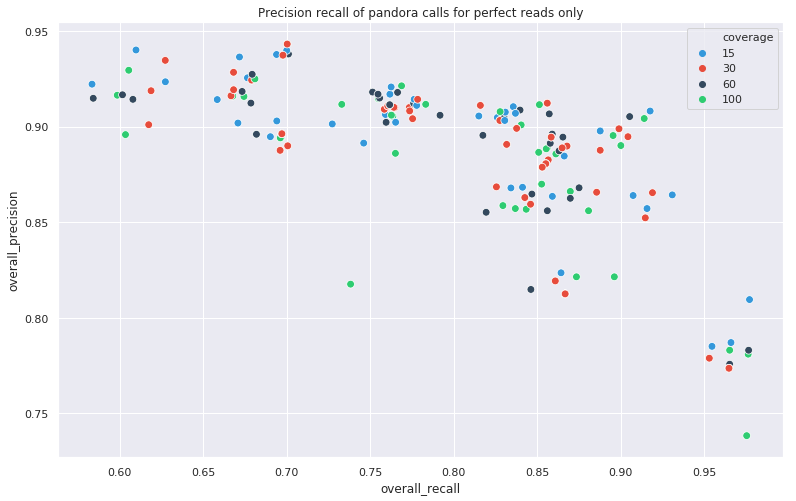

In [114]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")

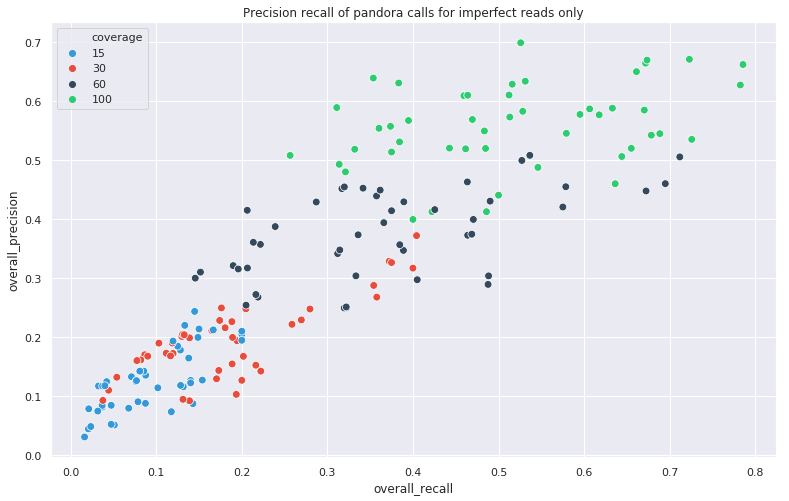

In [115]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="coverage", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")

For the `pandora` calls we see a very similar relationship as before: coverage doesn't effect the precision-recall relationship for perfect reads, but absolutelty does for imperfect reads.  

From this we can also say that, in the best case, for imperfect reads with 100x coverage ~65% of calls are correct (precision) and ~78% of the variants were, correctly, called (recall).
For perfect reads, we can also say that, in the best case, ~91% of calls are correct (precision) and ~92% of the variants were, correctly, called (recall). Additionally, coverage doesn't seem to play too big a role in this relationship, although it should be noted that, oddly, 60x coverage doesn't have as good results as the other coverage levels.

## Effect of maximum nesting level
When building the PRG one of the setting which can altered is the maximum level of nesting allowed in your graph. Here we assess how this parameter impacts the precision-recall relationship.

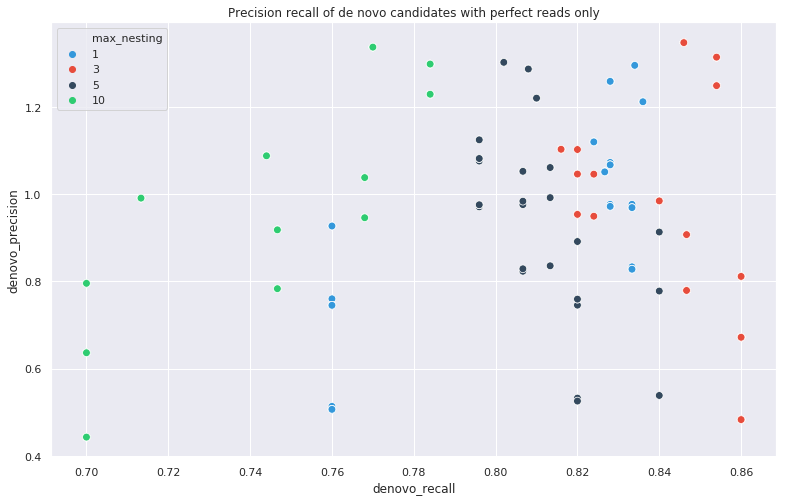

In [116]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")

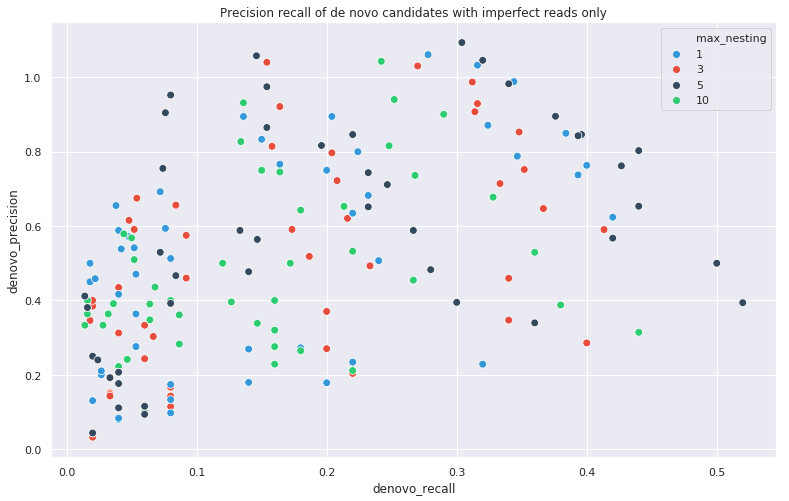

In [117]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")

When looking at the candidate paths produced by *de novo* the maximum PRG nesting level doesn't appear to have a dramatic effect on the precision recall relationship.  
One thing that is consistent for both perfect and imperfect reads is probably that a maximum nesting level of 10 seems to produce worse results.  

In summary, the discover of variants doesn't seem to depend to much on the maximum nesting level, although a value of 5 or below might be slightly beneficial.

And now looking at the same thing from the VCF output of `pandora`

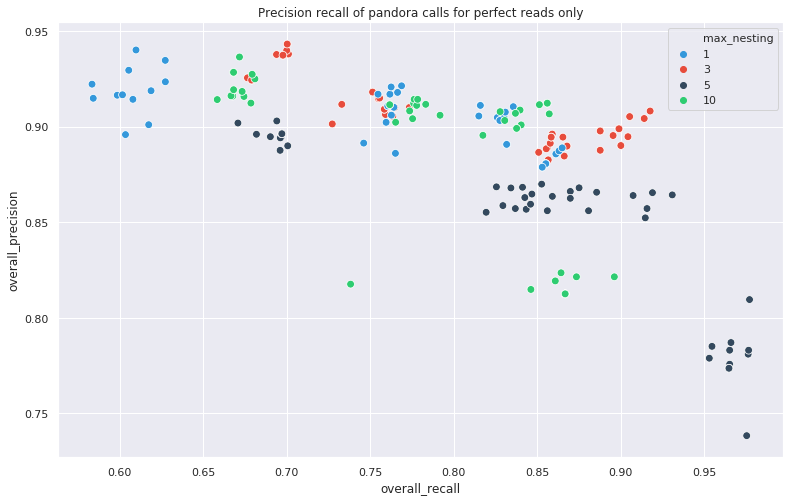

In [118]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")

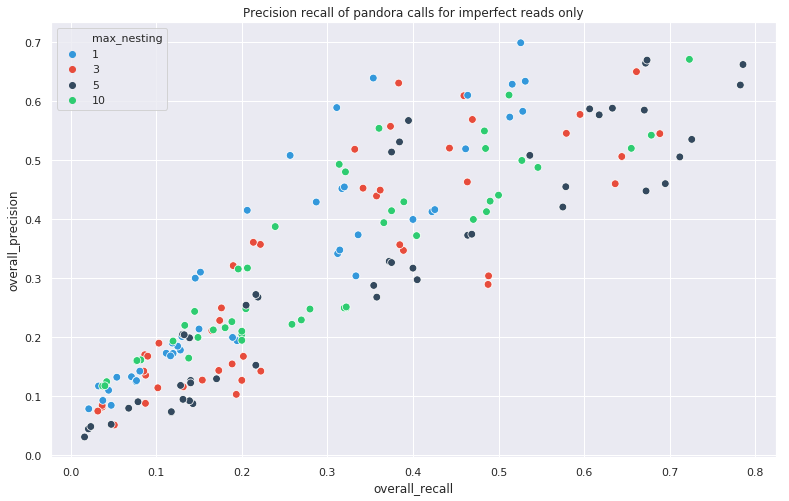

In [131]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="max_nesting", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")

The effective of maximum nesting level on the `pandora` call's precision-recall relationship seems to be much the same as the *de novo* candidate discovery.

In summary, the discover of variants doesn't seem to depend to much on the maximum nesting level, although a value of 3 or 5 or below might be slightly beneficial. **We would advocate the use of 5 as a default**.

## Effect of the number of SNPs
Bacterial species vary in their mutation rate and therefore we thought it would be useful to assess whether more or less SNPs per gene effects `pandora`'s ability to discover *de novo* mutations.  

*Note:* the number of SNPs in the plots is the number of SNPs per gene multiplied by the number of genes in total (50 in this case).

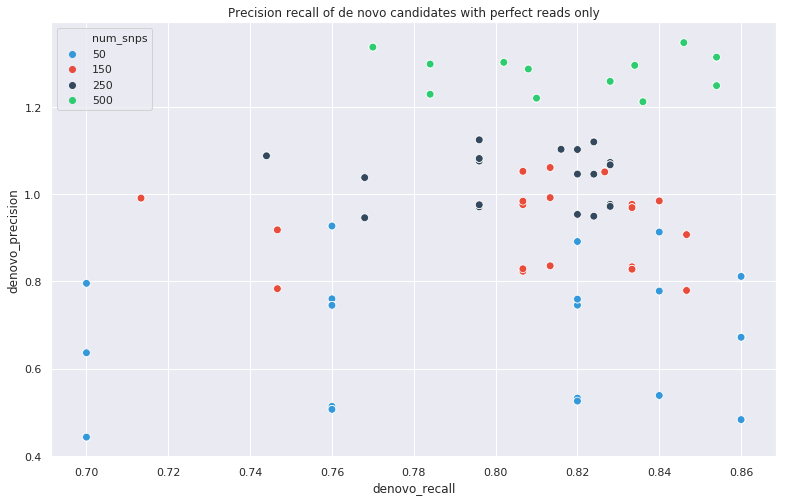

In [132]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP, 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with perfect reads only")

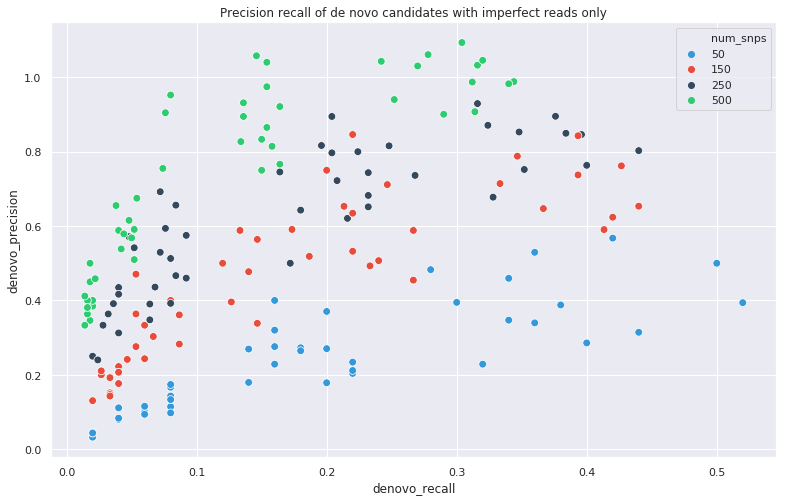

In [136]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax,
                       palette=CMAP, 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")

The relationship for the perfect reads can be summed up as the less SNPs per gene there is, the less candidate slices that contain a variant. Interestingly, 3 and 5 SNPs per gene fall around 100% of slices containing variants (precision). Once you get to 10 SNPs per gene the precision moves over 100%, meaning multiple SNPs are being found in the same slice. For the 1 SNP per gene we are finding 50-80% of slices contain a variant. This is probably a fairly expected relationship; the more SNPs there are, the more likely it is that a slice will contain a SNP. For the perfect reads it appears that the number of SNPs per gene has no effect on the recall.  

For the imperfect reads we see very much the same relationship as the perfect reads: precision increases with increasing number of SNPs per gene, however, the differences are more pronounced. We see that, at best, for the 1 SNP per gene samples we have ~55% of slices containing a variant, meaning we are running *de novo* discovery twice for every variant we find. In the average case for the 10 SNPs per gene samples, we get a variant every time we run *de novo* discovery. Again, the recall, i.e the percentage of variants we discover, does not seem to be exerting any effect on the number of SNPs, but you can very clearly see the impact that coverage has here. Each colour in the plot has a very distinct second-order polynomial relationship and if you lay coverage information over this you can see this relationship is defined purely by the amount of coverage (see below).

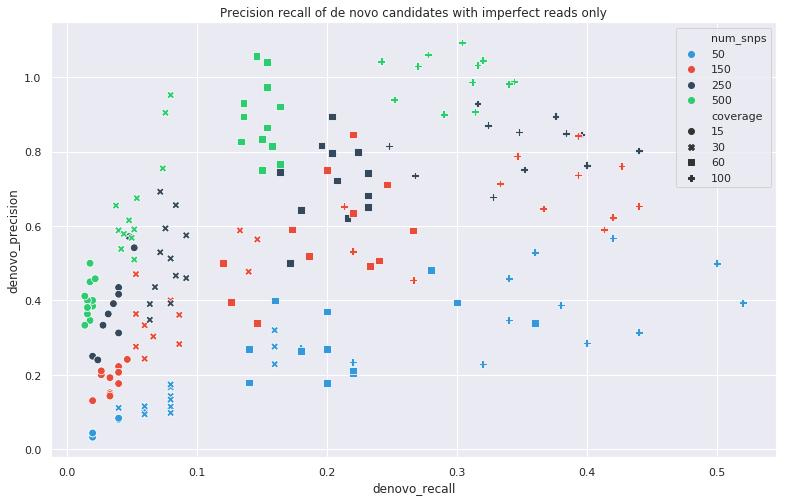

In [138]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax,
                       style="coverage",
                       palette=CMAP, 
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of de novo candidates with imperfect reads only")

And now looking at the same thing from the VCF output of `pandora`

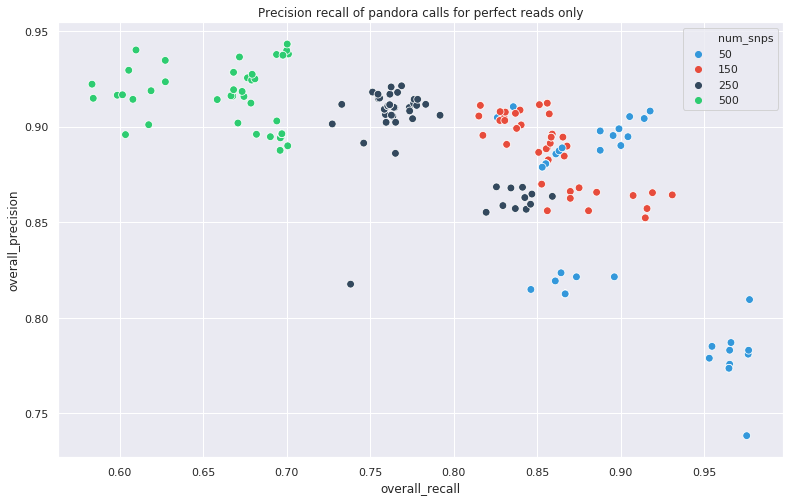

In [139]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for perfect reads only")

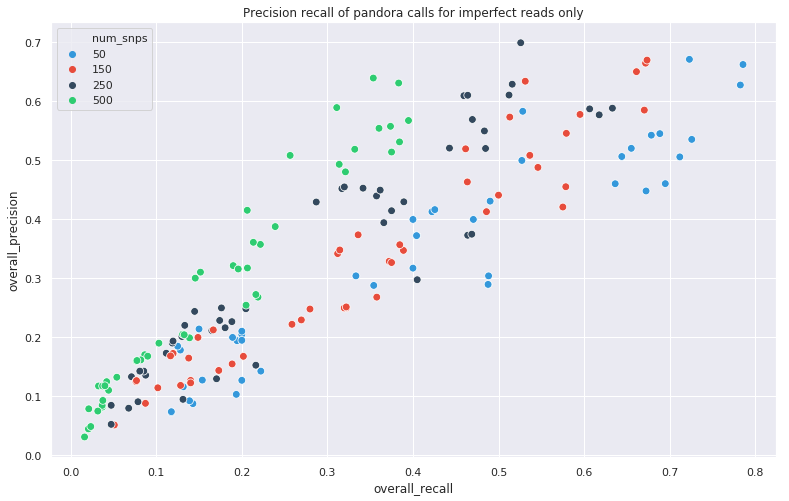

In [140]:
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       palette=CMAP,
                       hue="num_snps", 
                       legend="full", 
                       s=POINT_SIZE)
_ = plot.set(title="Precision recall of pandora calls for imperfect reads only")

The effect of the number of SNPs per gene on the precision-recall relationship for `pandora` calls is quite interesting.  
For perfect reads, we see that the more SNPs per gene we have, the less variants we are able to call. Inversely, the more SNPs per gene we have the *more* variants we call correctly. There is a fairly distinct separation between the 10 SNP per gene samples and other groupings.  

For the imperfect reads we actually see a bit of a different relationship than for the perfect reads. We do see the same relationship with respect to precision (% of variants we call correct) but it nowhere near as pronounced as it is for the perfect reads. However, the recall (% variants )

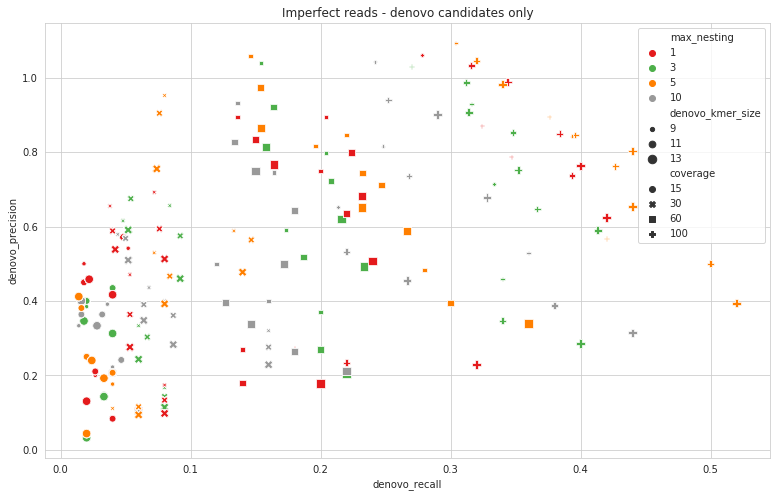

In [5]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full")
_ = plot.set(title="Imperfect reads - denovo candidates only")

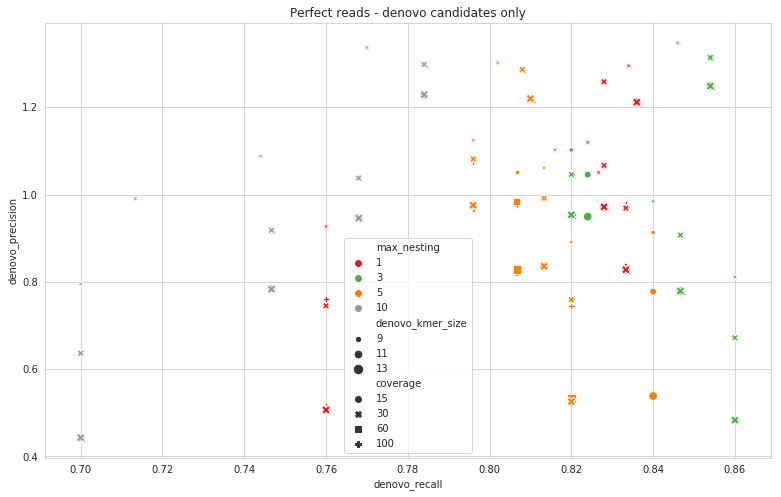

In [6]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="denovo_recall", 
                       y="denovo_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full")
_ = plot.set(title="Perfect reads - denovo candidates only")

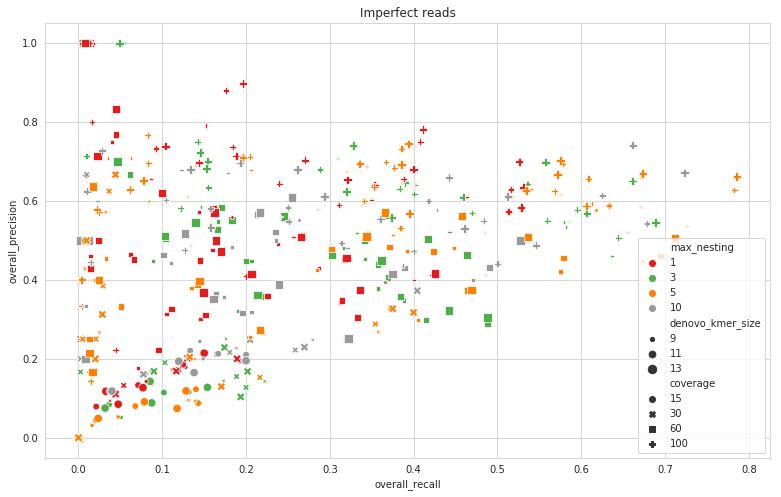

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full")
_ = plot.set(title="Imperfect reads")

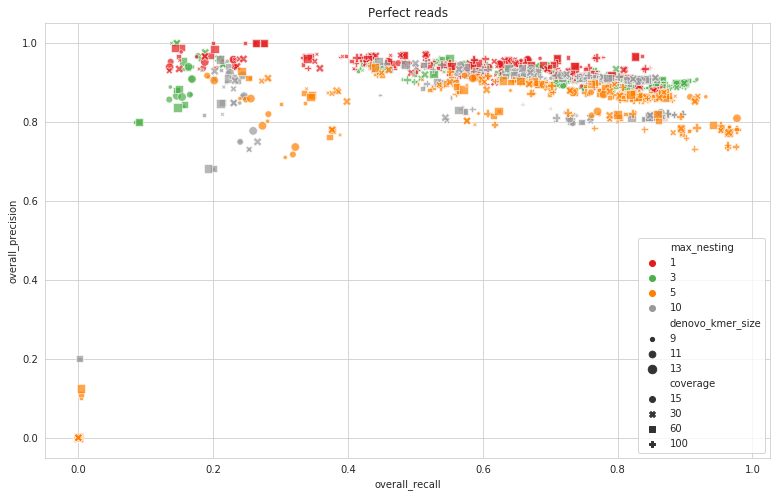

In [8]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full", alpha=0.7)
_ = plot.set(title="Perfect reads")

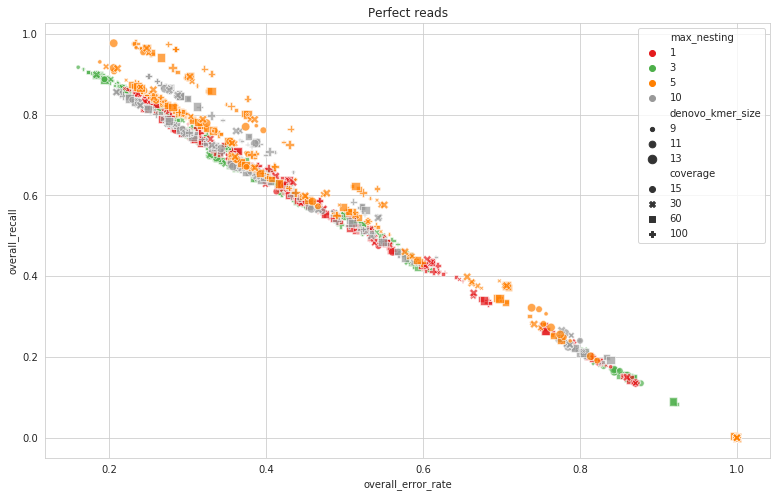

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=perfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full", alpha=0.7)
_ = plot.set(title="Perfect reads")

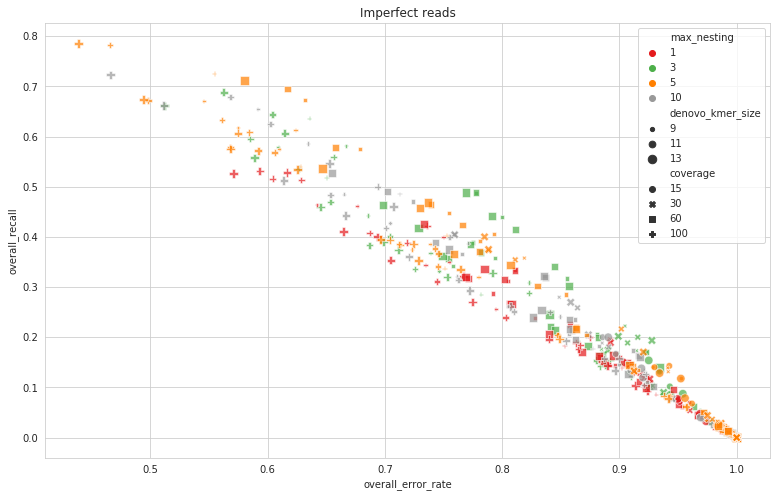

In [16]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax, 
                       style="coverage", 
                       hue="max_nesting", 
                       palette="Set1",
                       size="denovo_kmer_size", 
                       legend="full", alpha=0.7)
_ = plot.set(title="Imperfect reads")

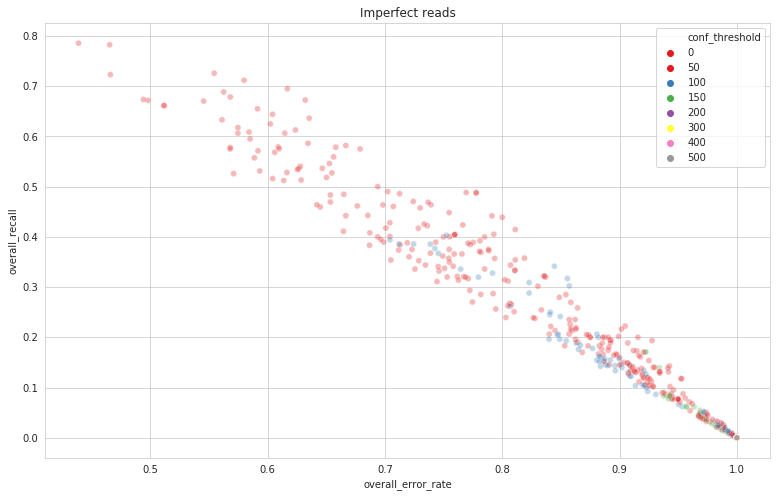

In [18]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_error_rate", 
                       y="overall_recall", 
                       data=imperfect_df, 
                       ax=ax,  
                       hue="conf_threshold", 
                       palette="Set1", 
                       legend="full", alpha=0.3)
_ = plot.set(title="Imperfect reads")

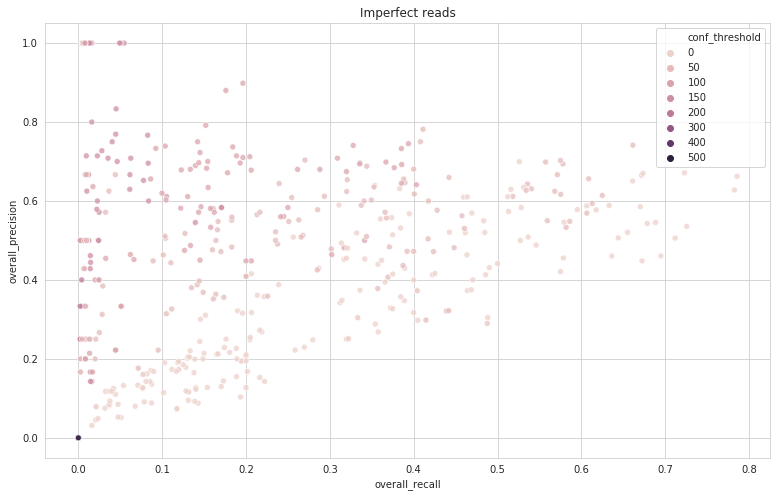

In [24]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=imperfect_df, 
                       ax=ax,  
                       hue="conf_threshold", 
#                        palette="Set3", 
                       legend="full", alpha=0.75)
_ = plot.set(title="Imperfect reads")

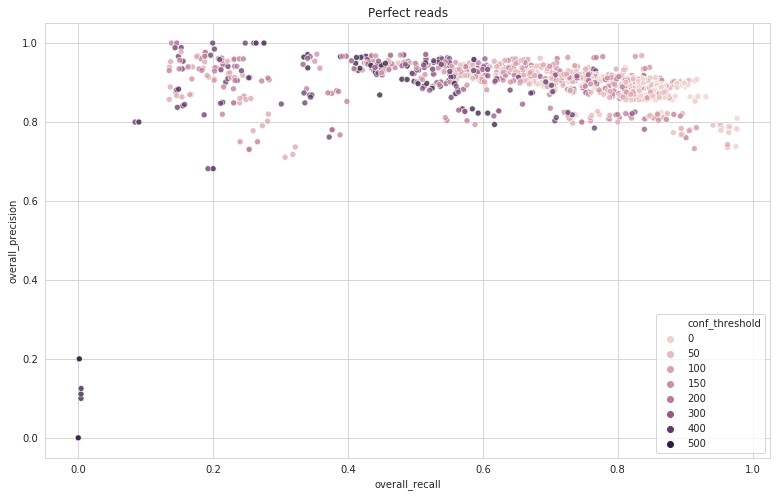

In [25]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=FIGSIZE)
plot = sns.scatterplot(x="overall_recall", 
                       y="overall_precision", 
                       data=perfect_df, 
                       ax=ax,  
                       hue="conf_threshold", 
#                        palette="Set3", 
                       legend="full", alpha=0.75)
_ = plot.set(title="Perfect reads")